# 2 Decision Trees
## 2.1 Trees on the Banana Dataset
### 2.1.1 Visualize decision boundary

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeClassifier

# Parameters
n_classes = 2
plot_colors = "by"
plot_step = 0.02

# Load data
train = pd.read_csv('./data/banana_train.csv', header=None, names=['target', 'X','Y'])

In [2]:
X = train.ix[:,1:3].as_matrix()
y = train.ix[:,0].as_matrix()

In [3]:
def relabel_y(y):
    if y == -1:
        return 0
    elif y == 1:
        return 1
    
v_relabel_y = np.vectorize(relabel_y)

In [4]:
# Shuffle
idx = np.arange(X.shape[0])
np.random.seed(13)
np.random.shuffle(idx)
X = X[idx]
y = y[idx]
y = v_relabel_y(y)

In [5]:
# Standardize
mean = X.mean(axis=0)
std = X.std(axis=0)
X = (X - mean) / std

# Train
clf = DecisionTreeClassifier().fit(X, y)

# Plot the decision boundary
plt.figure(figsize=(8,8))
           
x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, plot_step), np.arange(y_min, y_max, plot_step))

Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)
cs = plt.contourf(xx, yy, Z, cmap=plt.cm.Paired)

plt.xlabel('X')
plt.ylabel('Y')
plt.axis("tight")

# Plot the training points
for i, color in zip(range(n_classes), plot_colors):
    idx = np.where(y == i)
    plt.scatter(X[idx, 0], X[idx, 1], c=color, label='Class = {}'.format(i), cmap=plt.cm.Paired)

plt.title("Decision surface of decision tree")
plt.legend()
plt.savefig('./figures/2_1_1.png')

### 2.1.2 Comparing trees based on max_depth

In [6]:
## Note we will also determine train/test scores for part 2.1.3
test = pd.read_csv('./data/banana_test.csv', header=None, names=['target', 'X','Y'])
X_test = test.ix[:,1:3].as_matrix()
y_test = test.ix[:,0].as_matrix()
y_test = v_relabel_y(y_test)
mean = X_test.mean(axis=0)
std = X_test.std(axis=0)
X_test = (X_test - mean) / std

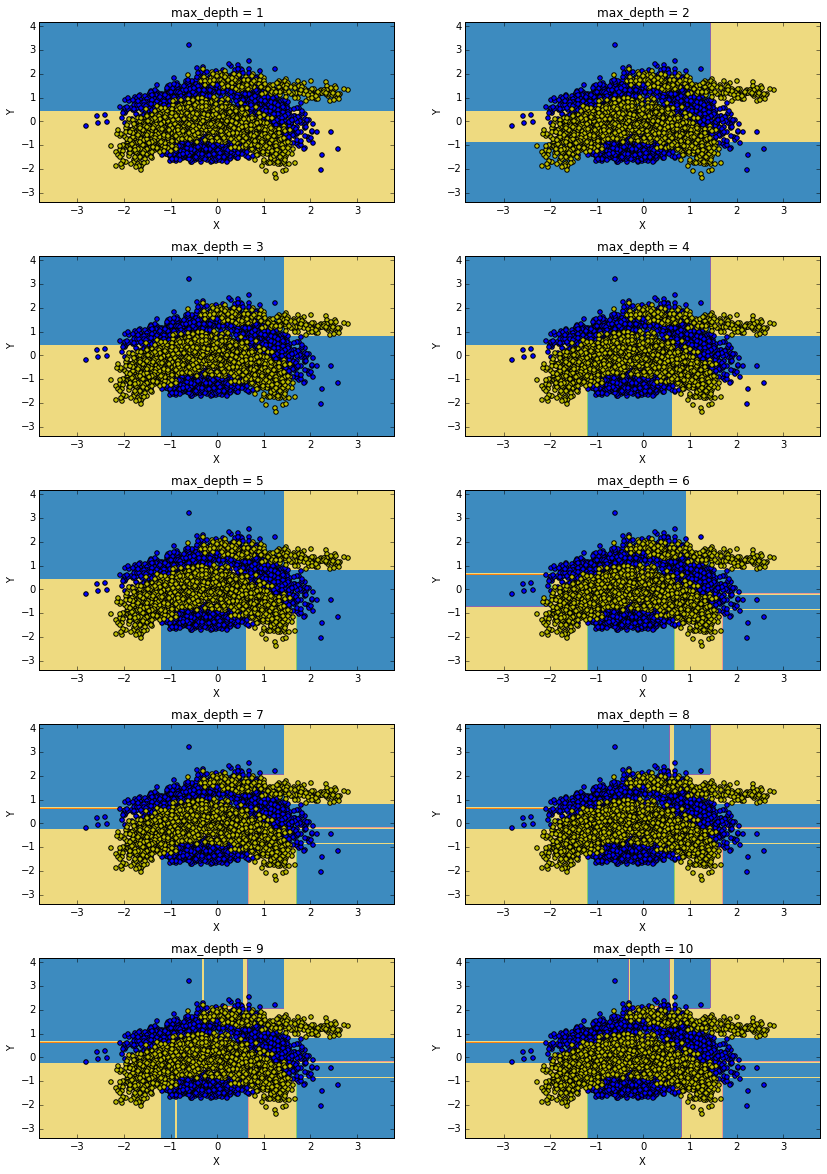

In [409]:
train_scores = []
test_scores = []

plt.figure(figsize =(14,20))
plt.subplots_adjust(hspace = .3)
for i in range(1,11):
    
    # Train
    clf = DecisionTreeClassifier(max_depth=i).fit(X, y)
    
    # Score
    train_scores.append(1.0 - clf.score(X, y))
    test_scores.append(1.0 - clf.score(X_test, y_test))
    
    # Plot
    plt.subplot(5,2,i)
    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    cs = plt.contourf(xx, yy, Z, cmap=plt.cm.Paired)

    plt.xlabel('X')
    plt.ylabel('Y')
    plt.axis("tight")

    # Plot the training points
    for j, color in zip(range(n_classes), plot_colors):
        idx = np.where(y == j)
        plt.scatter(X[idx, 0], X[idx, 1], c=color, label='Class = {}'.format(j), cmap=plt.cm.Paired)

    plt.title("max_depth = {}".format(i))
plt.savefig('./figures/2_1_2.png')

### 2.1.3 Training and test errors vs. max_depth

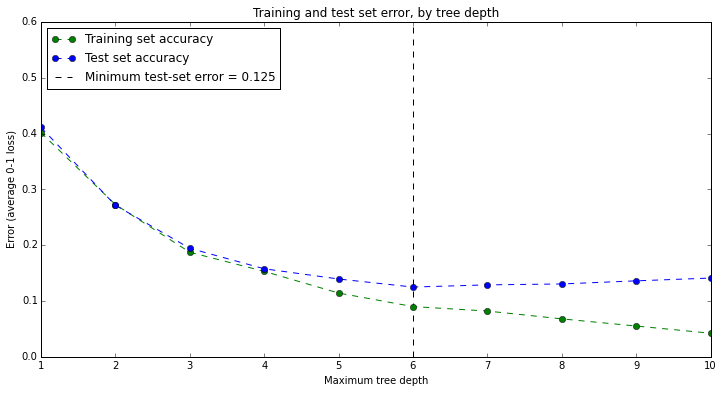

In [410]:
plt.figure(figsize=(12,6))
plt.plot(range(1,11),train_scores, color='green', linestyle='dashed', marker='o', label='Training set accuracy')
plt.plot(range(1,11),test_scores, color='blue', linestyle='dashed', marker='o', label='Test set accuracy')
plt.vlines(test_scores.index(min(test_scores))+1, 0, 0.6, colors='k', linestyles='dashed', label='Minimum test-set error = {}'.format(min(test_scores)))
plt.legend(loc = 'upper left')
plt.title('Training and test set error, by tree depth')
plt.ylabel('Error (average 0-1 loss)')
plt.xlabel('Maximum tree depth')
plt.savefig('./figures/2_1_3.png')

# 2.1.4 Optimizing other hyperparameters

In [7]:
from sklearn import grid_search

param_grid = [
  {'criterion': ['gini', 'entropy'],
   'max_depth' : range(1,11),
   'min_samples_split' : np.logspace(1,9,9, base=2),
   'min_samples_leaf' : np.logspace(0,9,10, base=2)}]

dt = DecisionTreeClassifier()
clf = grid_search.GridSearchCV(dt, param_grid)
clf.fit(X, y)

GridSearchCV(cv=None, error_score='raise',
       estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            random_state=None, splitter='best'),
       fit_params={}, iid=True, loss_func=None, n_jobs=1,
       param_grid=[{'min_samples_split': array([   2.,    4.,    8.,   16.,   32.,   64.,  128.,  256.,  512.]), 'criterion': ['gini', 'entropy'], 'max_depth': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10], 'min_samples_leaf': array([   1.,    2.,    4.,    8.,   16.,   32.,   64.,  128.,  256.,  512.])}],
       pre_dispatch='2*n_jobs', refit=True, score_func=None, scoring=None,
       verbose=0)

In [8]:
clf.best_score_

0.89114285714285713

In [9]:
clf.best_params_

{'criterion': 'gini',
 'max_depth': 9,
 'min_samples_leaf': 8.0,
 'min_samples_split': 2.0}

In [12]:
1 - clf.score(X_test, y_test)

0.13722222222222225

# 3 AdaBoost
## 3.1 Implementation
### 3.1.1 Implementing with depth 3 trees as base classifier

In [415]:
##Need -1, 1 y's for Ada_boost:
def inv_relabel_y(y):
    if y == 1:
        return 1
    elif y == 0:
        return -1
    else:
        return y
    
v_inv_relabel_y = np.vectorize(inv_relabel_y)

In [416]:
y = v_inv_relabel_y(y)
y_test = v_inv_relabel_y(y_test)

In [417]:
##Mutates input weights
def update_weights(weights, alpha, loss_vector):
    weights[loss_vector == 1,] = weights[loss_vector == 1,]*np.e**(alpha)
    return weights

In [418]:
def AdaBoost(X_train, y_train, num_iter):
    ## Initialize weights
    n = X_train.shape[0]
    weights = np.ones(n)/float(n)
    
    ## Initialize lists to store alphas and trees
    alphas = []
    trees = []
    
    for m in range(num_iter):
        clf = DecisionTreeClassifier(max_depth=3).fit(X_train, y_train, sample_weight=weights)
        loss_vector = np.not_equal(clf.predict(X_train),y_train)
        err = 1.0/(np.sum(weights))*np.dot(weights,loss_vector)
        alpha = np.log((1.0-err)/err)
        update_weights(weights, alpha, loss_vector)
        alphas.append(alpha)
        trees.append(clf)
    
    return weights, alphas, trees

In [419]:
def predict_label_from_classifiers(X_s, alphas, trees):
    predictions = np.zeros(X_s.shape[0])
    for m in range(len(alphas)):
        predictions = predictions + alphas[m]*trees[m].predict(X_s)
    
    return np.sign(predictions)

In [420]:
def unsigned_score(X_s, alphas, trees):
    predictions = np.zeros(X_s.shape[0])
    for m in range(len(alphas)):
        predictions = predictions + alphas[m]*trees[m].predict(X_s)
        
    return predictions

In [421]:
def prediction_error(prediction, truth):
    return np.sum(np.not_equal(prediction, truth))/float(len(truth))

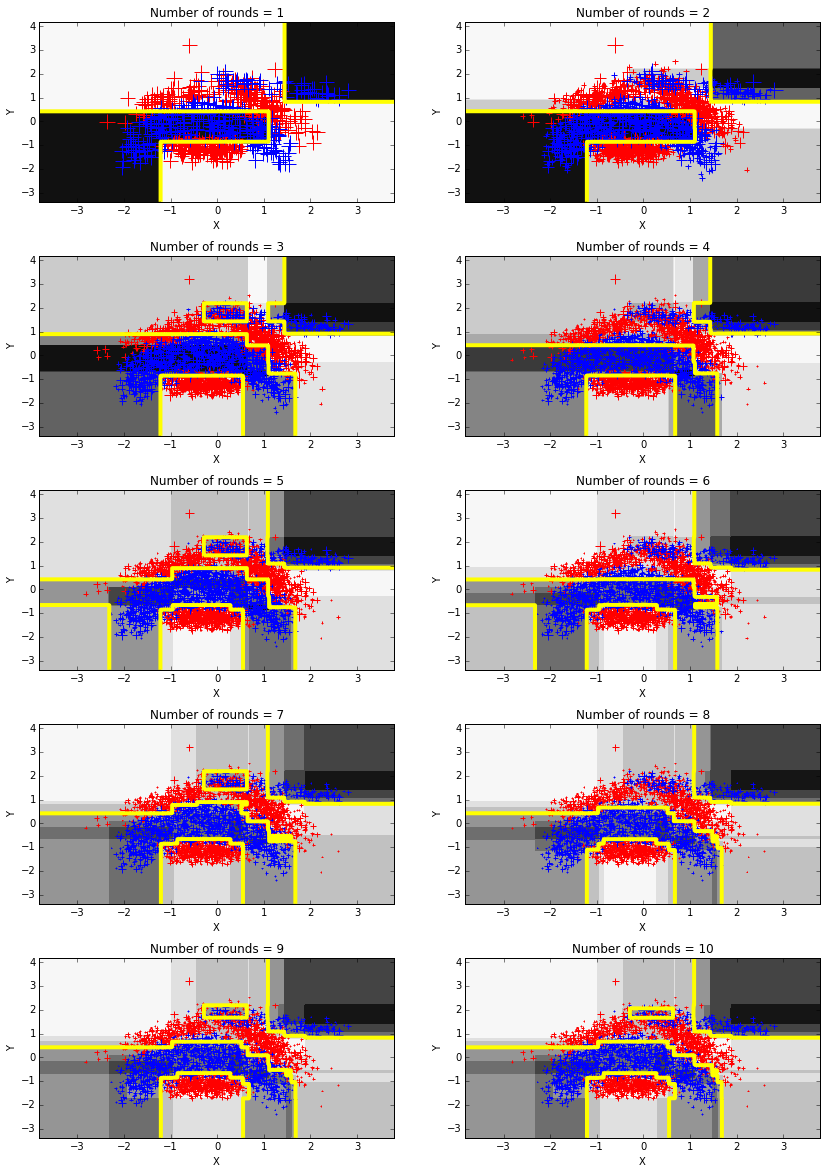

In [422]:
train_errors = []
test_errors = []

plt.figure(figsize =(14,20))
plt.subplots_adjust(hspace = .3)

for num_iter in range(1,11):
    
    # Train
    weights, alphas, trees = AdaBoost(X, y, num_iter)
    
    # Scale the weights for plotting
    weights = (weights-np.min(weights))/np.max(weights) * 300

    #Score
    y_hat_train = predict_label_from_classifiers(X, alphas, trees)
    train_errors.append(prediction_error(y_hat_train, y))
    y_hat_test = predict_label_from_classifiers(X_test, alphas, trees)
    test_errors.append(prediction_error(y_hat_test,y_test))
    
    plt.subplot(5,2,num_iter)
    Z = unsigned_score(np.c_[xx.ravel(), yy.ravel()], alphas, trees)
    Z = Z.reshape(xx.shape)
    cs = plt.contourf(xx, yy, Z, cmap=plt.cm.Greys)
    cs_lines = plt.contour(xx, yy, Z, levels=[0.0],linewidths=4, colors='#ffff00')

    plt.xlabel('X')
    plt.ylabel('Y')
    plt.axis("tight")

    # Plot the training points
    for j, color in zip([-1,1], 'rb'):
        idx = np.where(y == j)
        plt.scatter(X[idx, 0], X[idx, 1], c=color, marker='+', s=weights)

    plt.title("Number of rounds = {}".format(num_iter))
    
plt.savefig('./figures/3_1_2.png')
    

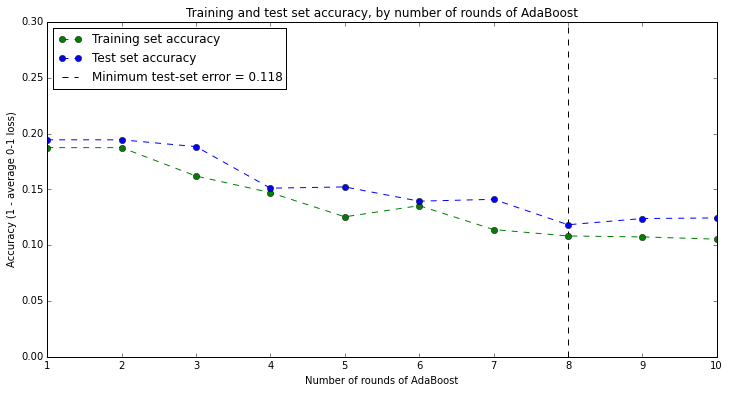

In [423]:
plt.figure(figsize=(12,6))
plt.plot(range(1,11),train_errors, color='green', linestyle='dashed', marker='o', label='Training set accuracy')
plt.plot(range(1,11),test_errors, color='blue', linestyle='dashed', marker='o', label='Test set accuracy')
plt.vlines(test_errors.index(min(test_errors))+1, 0, 0.3, colors='k', linestyles='dashed', label='Minimum test-set error = {}'.format(round(min(test_errors),3)))
plt.legend(loc = 'upper left')
plt.title('Training and test set accuracy, by number of rounds of AdaBoost')
plt.ylabel('Accuracy (1 - average 0-1 loss)')
plt.xlabel('Number of rounds of AdaBoost')
plt.savefig('./figures/3_1_3.png')